In [1]:
%matplotlib inline
%run 'notebook_utils.py'

import sys
import pprint
import cProfile

import matplotlib.pyplot as plt
import numpy             as np

import radical.utils     as ru
import radical.pilot     as rp
import radical.analytics as ra

from   radical.utils.profile import *
from   radical.pilot.states  import *
import glob
from matplotlib.ticker import MaxNLocator

In [2]:
# Load wrangled data saved in .csv files for both synapse, microbenchmarks and gromacs.
sessions = pd.read_csv('../null_continuous_fifo/stress-ng-10-mins/sessions.csv', index_col=0)
pilots = pd.read_csv('../null_continuous_fifo/stress-ng-10-mins/pilots.csv', index_col=0)
wrangler_units = pd.read_csv('../null_continuous_fifo/stress-ng-10-mins/units.csv', index_col=0)

In [3]:
print 'Synapse: Weak Scaling: Total number of successful runs: %s' % sessions.shape[0]
print 'Synapse: Weak Scaling: Total number of pilots: %s' % pilots.shape[0]
print 'Synapse: Weak Scaling: Total number of units: %s\n' % wrangler_units.shape[0]

Synapse: Weak Scaling: Total number of successful runs: 1
Synapse: Weak Scaling: Total number of pilots: 1
Synapse: Weak Scaling: Total number of units: 80



## Get timestamps for all units in `cu_exec_start`, `cu_exec_stop`

In [4]:
rp_folder = glob.glob('../null_continuous_fifo/stress-ng-10-mins/stress_ng_10_mins/rp.*')
re_folder = glob.glob('../null_continuous_fifo/stress-ng-10-mins/stress_ng_10_mins/re.*')

src = rp_folder[0]
session = ra.Session(stype='radical.pilot', src=src)
src = '/Users/JumanaDakka/git/htbac-escience-18/null_continuous_fifo/stress-ng-10-mins/stress_ng_10_mins'

enTK_session = ra.Session(stype = 'radical.entk', src = src, sid = 're.session.two.jdakka.017737.0002')
enTK_states = enTK_session.list('state') # EXECUTED
enTK_tasks = enTK_session.filter(etype = 'task') # , uid = task_ids

units = session.filter(etype = 'unit', inplace = True)

# uid = units_ids,
rp_cu_exec_start = []
rp_cu_exec_stop = []
rp_agent_executing = []
rp_done = []


# events
rp_cu_exec_start = units.timestamps(event = [{ru.EVENT: 'cu_exec_start'}])
rp_cu_exec_stop = units.timestamps(event = [{ru.EVENT: 'cu_exec_stop'}])
rp_cu_exec_start = pd.DataFrame(rp_cu_exec_start, columns = ['cu exec start'])
rp_cu_exec_stop = pd.DataFrame(rp_cu_exec_stop, columns = ['cu exec stop'])

# states
rp_agent_executing = units.timestamps(event = [{ru.STATE: rp.AGENT_SCHEDULING}])
rp_agent_executing = [rp_agent_executing[i] for i in range(len(rp_agent_executing)) if i%2==0]
rp_agent_executing = pd.DataFrame(rp_agent_executing, columns = ['AGENT SCHEDULING'])
rp_done = pd.DataFrame(wrangler_units['DONE'].tolist(), columns=['DONE (RP)'])

units_1 = session.filter(etype='unit', inplace=False, uid=sorted(session.list('uid'))[0:20])
units_2 = session.filter(etype='unit', inplace=False, uid=sorted(session.list('uid'))[20:40])
u1_exec = units_1.duration(state=['UMGR_SCHEDULING','DONE'])
u2_exec = units_2.duration(state=['UMGR_SCHEDULING','DONE'])

# EnTK States

re_submitted = enTK_tasks.timestamps(state = 'SUBMITTED')
re_submitted = pd.DataFrame(re_submitted, columns = ['SUBMITTED (EnTK)'])
re_executed = enTK_tasks.timestamps(state = 'EXECUTED')
re_executed = pd.DataFrame(re_executed, columns = ['EXECUTED (EnTK)'])
re_done = enTK_tasks.timestamps(state = 'DONE')
re_done = pd.DataFrame(re_done, columns = ['DONE (EnTK)'])

df = pd.concat([re_submitted, rp_agent_executing, rp_cu_exec_start, rp_cu_exec_stop, rp_done, re_executed, re_done],  axis=1)

## Stage 1 Tasks

In [5]:
stage_1 = df[0:20]
stage_1_as = stage_1['AGENT SCHEDULING']
stage_1

,SUBMITTED (EnTK),AGENT SCHEDULING,cu exec start,cu exec stop,DONE (RP),EXECUTED (EnTK),DONE (EnTK)
0,28621.0043,28623.6319,28623.7560,29250.3141,29252.4526,29252.5737,29252.6068
1,28621.0154,28623.6319,28623.7806,29250.3908,29252.4526,29252.5928,29252.6436
2,28621.0214,28623.6319,28623.8325,29250.7205,29252.4526,29252.6231,29252.6936
3,28621.0302,28623.6319,28623.8854,29250.9781,29252.4526,29252.6658,29252.7275
4,28621.0361,28623.6319,28623.9374,29250.9968,29252.4526,29252.7051,29252.7549
5,28621.0446,28623.6319,28623.9903,29251.0091,29252.4526,29252.7288,29252.7830
6,28621.0542,28623.6319,28624.0426,29251.0100,29252.4526,29252.7556,29252.8081
7,28621.0765,28623.6319,28624.0948,29251.0270,29252.4526,29252.7873,29252.8251
8,28621.0853,28623.6319,28624.1478,29251.0287,29252.4526,29252.8079,29252.8563
9,28621.0937,28623.6319,28624.2013,29251.0341,29252.4526,29252.8313,29252.8913


## Stage 2 Tasks

In [6]:
stage_2 = df[20:40]
stage_2_as = stage_2['AGENT SCHEDULING']
stage_2

,SUBMITTED (EnTK),AGENT SCHEDULING,cu exec start,cu exec stop,DONE (RP),EXECUTED (EnTK),DONE (EnTK)
20,29254.1090,29256.0862,29256.1793,29869.4104,29877.8101,29872.3813,29872.4297
21,29254.1248,29256.0862,29256.2331,29874.8499,29879.0976,29877.9876,29878.0118
22,29254.1280,29256.0862,29256.2866,29875.2633,29877.8101,29878.0130,29878.0382
23,29254.1314,29256.0862,29256.3391,29875.6006,29877.8101,29878.0620,29878.0814
24,29254.1405,29256.0862,29256.3911,29875.6351,29877.8101,29878.0819,29878.1160
25,29254.1480,29256.0862,29256.4504,29875.6618,29877.8101,29878.1115,29878.1487
26,29254.1607,29256.0862,29256.5054,29876.0424,29877.8101,29878.1241,29878.1784
27,29254.1654,29256.0862,29256.5570,29876.0545,29877.8101,29878.1603,29878.2266
28,29254.1751,29256.0862,29256.6097,29876.0722,29877.8101,29878.1756,29878.2758
29,29254.1786,29256.0862,29256.6639,29876.0899,29877.8101,29878.1932,29878.2869


## Stage 3 Tasks

In [7]:
stage_3 = df[40:60]
stage_3_as = stage_3['AGENT SCHEDULING']
stage_3

,SUBMITTED (EnTK),AGENT SCHEDULING,cu exec start,cu exec stop,DONE (RP),EXECUTED (EnTK),DONE (EnTK)
40,29878.8179,29879.6451,29879.7381,30496.8722,30501.9680,30499.2416,30499.2630
41,29878.8359,29879.6451,29879.7921,30496.9161,30501.9680,30499.2924,30499.3173
42,29878.8407,29879.6451,29879.8451,30497.4418,30501.9680,30499.3434,30499.3568
43,29878.8504,29879.6451,29879.8973,30498.4511,30501.9680,30500.6069,30500.6237
44,29878.8586,29879.6451,29879.9516,30499.3165,30499.1157,30502.1310,30502.1519
45,29878.8710,29879.6451,29880.0042,30499.5862,30501.9680,30502.1519,30502.1948
46,29878.8795,29879.6451,29880.0593,30500.1139,30500.4947,30502.1869,30502.2106
47,29878.8856,29879.6451,29880.1100,30500.1744,30499.1157,30502.2105,30502.2522
48,29878.8914,29879.6451,29880.1637,30500.3491,30499.1157,30502.2468,30502.3028
49,29878.8948,29879.6451,29880.2156,30500.3646,30501.9680,30502.2790,30502.3342


## Stage 4 Tasks

In [8]:
stage_4 = df[60:80]
stage_4_as = stage_4['AGENT SCHEDULING']
stage_4

,SUBMITTED (EnTK),AGENT SCHEDULING,cu exec start,cu exec stop,DONE (RP),EXECUTED (EnTK),DONE (EnTK)
60,30502.7168,30504.1238,30504.2348,31150.7150,31152.8365,31152.9929,31153.0152
61,30502.7387,30504.1238,30504.2900,31150.7172,31152.8365,31153.0064,31153.0671
62,30502.7445,30504.1238,30504.3290,31150.7178,31152.8365,31153.0209,31153.0882
63,30502.7510,30504.1238,30504.3829,31150.7186,31152.8365,31153.0501,31153.1447
64,30502.7606,30504.1238,30504.4347,31150.7217,31152.8365,31153.1022,31153.1649
65,30502.7761,30504.1238,30504.5777,31150.7219,31152.8365,31153.1493,31153.1921
66,30502.7864,30504.1238,30504.5945,31150.7227,31152.8365,31153.1762,31153.2281
67,30502.8000,30504.1238,30504.6761,31150.7252,31152.8365,31153.2162,31153.2737
68,30502.8036,30504.1238,30504.7256,31150.7252,31152.8365,31153.2468,31153.3083
69,30502.8108,30504.1238,30504.7763,31150.7265,31152.8365,31153.2781,31153.3331


### Each subplot presents the data for an EnTK stage (1-4). 


/Users/JumanaDakka/environments/ve_entk_0.7_rp_0.5/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


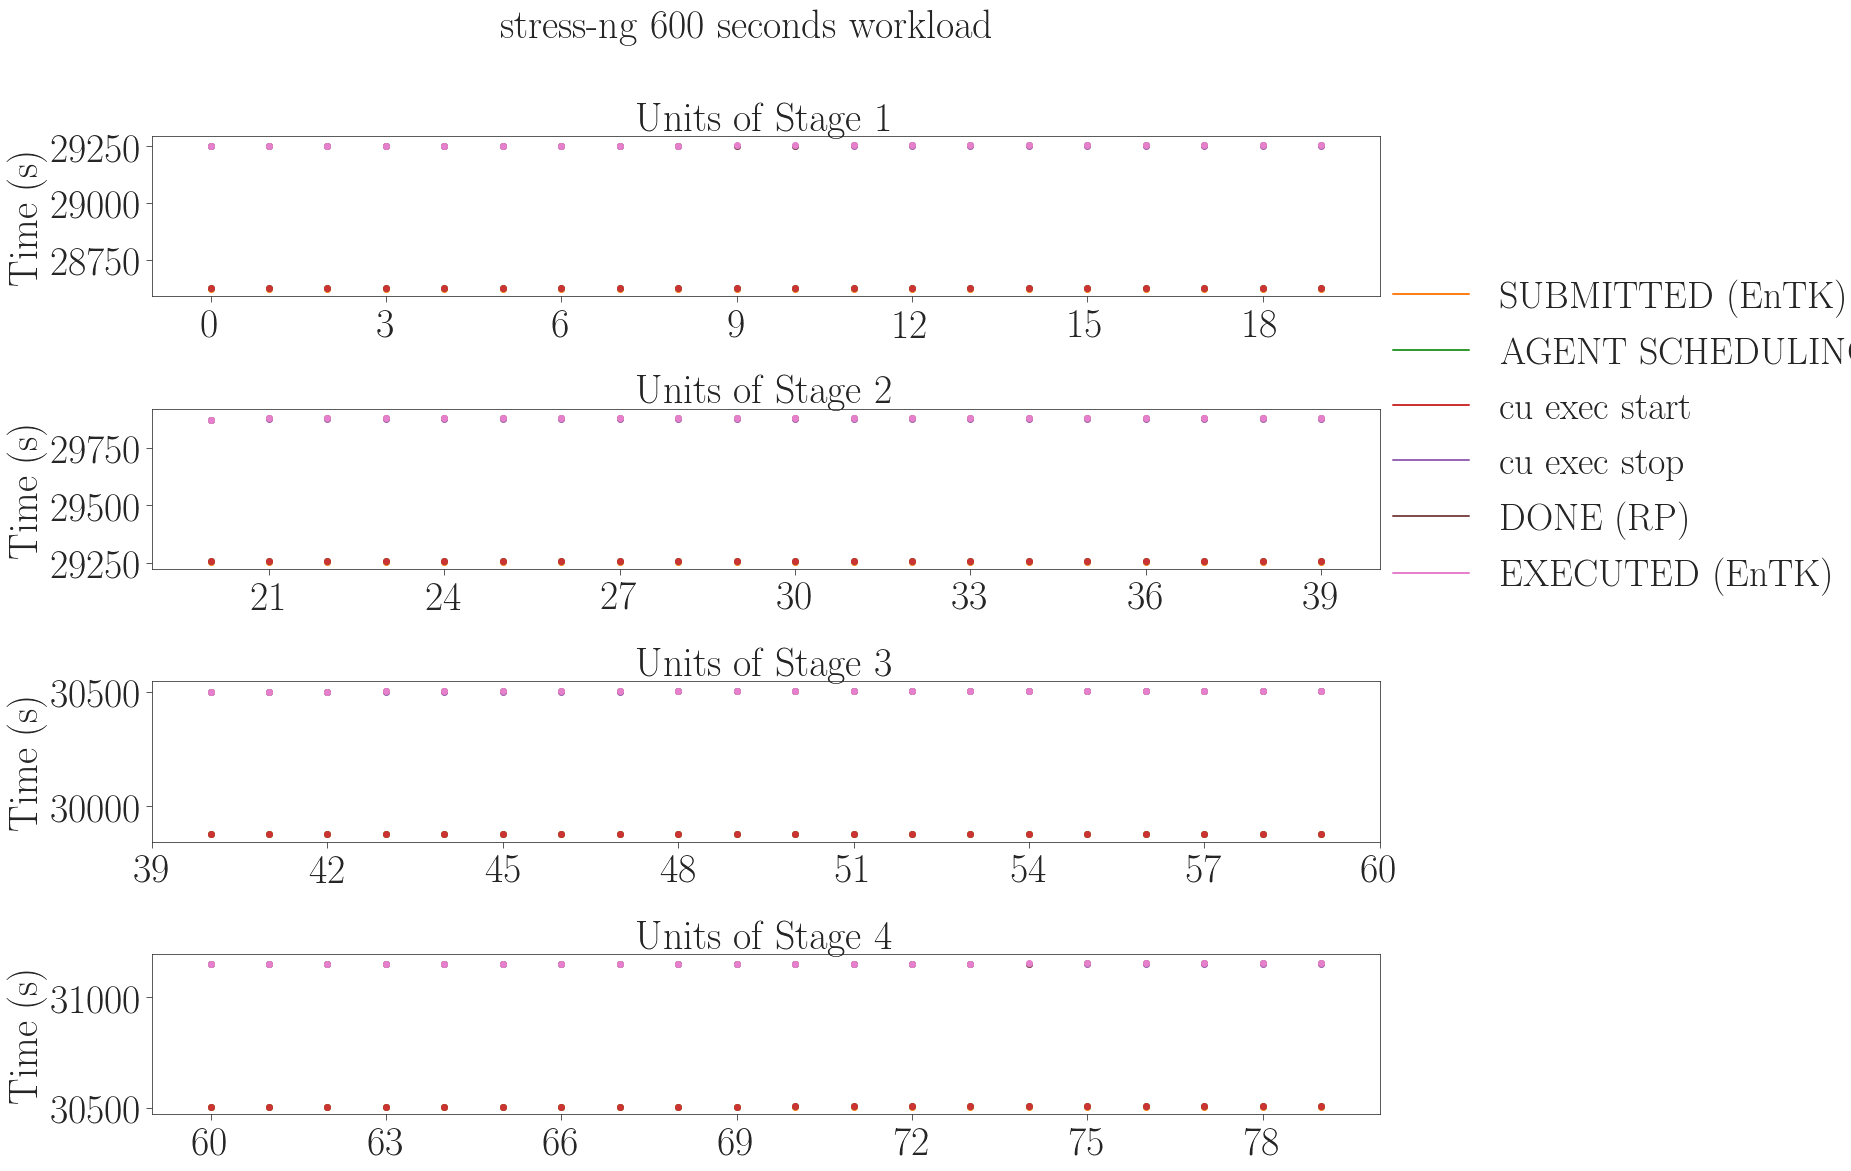

In [9]:
# nunits = concurrent units 
nunits = [1,2,3,4]
fwidth = 32
fhight = 10

fig, axarr = plt.subplots(4, figsize=(22,18))
fig.suptitle('stress-ng 600 seconds workload')
axarr[0].scatter(stage_1['SUBMITTED (EnTK)'].index, stage_1['SUBMITTED (EnTK)'],  marker='o', color=tableau20[2])
axarr[0].scatter(stage_1['AGENT SCHEDULING'].index, stage_1['AGENT SCHEDULING'],  marker='o', color=tableau20[4])
axarr[0].scatter(stage_1['cu exec start'].index, stage_1['cu exec start'],  marker='o', color=tableau20[6])
axarr[0].scatter(stage_1['cu exec start'].index, stage_1['cu exec stop'],  marker='o', color=tableau20[8])
axarr[0].scatter(stage_1['EXECUTED (EnTK)'].index, stage_1['EXECUTED (EnTK)'],  marker='o', color=tableau20[10])
axarr[0].scatter(stage_1['DONE (EnTK)'].index, stage_1['DONE (EnTK)'],  marker='o', color=tableau20[12])
axarr[0].set_xlim(-1,20)
axarr[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axarr[0].set_ylabel('Time (s)')
axarr[0].set_title('Units of Stage 1')


axarr[1].scatter(stage_2['SUBMITTED (EnTK)'].index, stage_2['SUBMITTED (EnTK)'],  marker='o', color=tableau20[2])
axarr[1].scatter(stage_2['AGENT SCHEDULING'].index, stage_2['AGENT SCHEDULING'],  marker='o', color=tableau20[4])
axarr[1].scatter(stage_2['cu exec start'].index, stage_2['cu exec start'],  marker='o', color=tableau20[6])
axarr[1].scatter(stage_2['cu exec start'].index, stage_2['cu exec stop'],  marker='o', color=tableau20[8])
axarr[1].scatter(stage_2['EXECUTED (EnTK)'].index, stage_2['EXECUTED (EnTK)'],  marker='o', color=tableau20[10])
axarr[1].scatter(stage_2['DONE (EnTK)'].index, stage_2['DONE (EnTK)'],  marker='o', color=tableau20[12])
axarr[1].set_title('Units of Stage 2')
axarr[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axarr[1].set_ylabel('Time (s)')
axarr[1].set_xlim(19,40)
#axarr[1].set_ylim(29200,30000)
# axarr[1].set_yticklabels([29250,29250,29250,29750])
# axarr[1].yaxis.set_major_locator(MaxNLocator(integer=True))

axarr[2].scatter(stage_3['SUBMITTED (EnTK)'].index, stage_3['SUBMITTED (EnTK)'],  marker='o', color=tableau20[2])
axarr[2].scatter(stage_3['AGENT SCHEDULING'].index, stage_3['AGENT SCHEDULING'],  marker='o', color=tableau20[4])
axarr[2].scatter(stage_3['cu exec start'].index, stage_3['cu exec start'],  marker='o', color=tableau20[6])
axarr[2].scatter(stage_3['cu exec start'].index, stage_3['cu exec stop'],  marker='o', color=tableau20[8])
axarr[2].scatter(stage_3['EXECUTED (EnTK)'].index, stage_3['EXECUTED (EnTK)'],  marker='o', color=tableau20[10])
axarr[2].scatter(stage_3['DONE (EnTK)'].index, stage_3['DONE (EnTK)'],  marker='o', color=tableau20[12])
axarr[2].set_title('Units of Stage 3')
axarr[2].set_xlim(39,60)
axarr[2].xaxis.set_major_locator(MaxNLocator(integer=True))
#axarr[2].set_yticklabels([29750,30000,30000,30500])
axarr[2].set_ylabel('Time (s)')

axarr[3].scatter(stage_4['SUBMITTED (EnTK)'].index, stage_4['SUBMITTED (EnTK)'],  marker='o', color=tableau20[2])
axarr[3].scatter(stage_4['AGENT SCHEDULING'].index, stage_4['AGENT SCHEDULING'],  marker='o', color=tableau20[4])
axarr[3].scatter(stage_4['cu exec start'].index, stage_4['cu exec start'],  marker='o', color=tableau20[6])
axarr[3].scatter(stage_4['cu exec start'].index, stage_4['cu exec stop'],  marker='o', color=tableau20[8])
axarr[3].scatter(stage_4['EXECUTED (EnTK)'].index, stage_4['EXECUTED (EnTK)'],  marker='o', color=tableau20[10])
axarr[3].scatter(stage_4['DONE (EnTK)'].index, stage_4['DONE (EnTK)'],  marker='o', color=tableau20[12])
axarr[3].set_title('Units of Stage 4')
axarr[3].set_xlim(59,80)
axarr[3].xaxis.set_major_locator(MaxNLocator(integer=True))
axarr[3].set_ylabel('Time (s)')

fig.subplots_adjust(hspace=0.7)
fig.legend((
                mpl.lines.Line2D([], [], color=tableau20[2]),
                mpl.lines.Line2D([], [], color=tableau20[4]),
                mpl.lines.Line2D([], [], color=tableau20[6]),
                mpl.lines.Line2D([], [], color=tableau20[8]),
                mpl.lines.Line2D([], [], color=tableau20[10]),
                mpl.lines.Line2D([], [], color=tableau20[12])
           ),
           (
                'SUBMITTED (EnTK)',
                'AGENT SCHEDULING',
                'cu exec start',
                'cu exec stop',
                'DONE (RP)',
                'EXECUTED (EnTK)',
                'DONE (EnTK)'
           ),
            bbox_to_anchor=(.87, .7), loc=2, borderaxespad=0.)


# fig.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('stress-ng-600-seconds-2P.pdf', dpi=300, bbox_inches='tight')
plt.savefig('stress-ng-600-seconds-2P.png', dpi=300, bbox_inches='tight')


In [33]:


# segregate into pipelines 


stage_1_as_p1 = stage_1['AGENT SCHEDULING'][0:10].mean()
stage_1_do_p1 = stage_1['DONE (EnTK)'][0:10].mean()

stage_1_as_p2 = stage_1['AGENT SCHEDULING'][10:20].mean()
stage_1_do_p2 = stage_1['DONE (EnTK)'][10:20].mean()

stage_2_as_p1 = stage_2['AGENT SCHEDULING'][0:10].mean()
stage_2_do_p1 = stage_2['DONE (EnTK)'][0:10].mean()

stage_2_as_p2 = stage_2['AGENT SCHEDULING'][0:10].mean()
stage_2_do_p2 = stage_2['DONE (EnTK)'][0:10].mean()

stage_3_as_p1 = stage_3['AGENT SCHEDULING'][0:10].mean()
stage_3_do_p1 = stage_3['DONE (EnTK)'][0:10].mean()

stage_3_as_p2 = stage_3['AGENT SCHEDULING'][10:20].mean()
stage_3_do_p2 = stage_3['DONE (EnTK)'][10:20].mean()

stage_4_as_p1 = stage_4['AGENT SCHEDULING'][0:10].mean()
stage_4_do_p1 = stage_4['DONE (EnTK)'][0:10].mean()

stage_4_as_p2 = stage_4['AGENT SCHEDULING'][10:20].mean()
stage_4_do_p2 = stage_4['DONE (EnTK)'][10:20].mean()

data = {'Pipeline 1': [stage_1_as_p1, stage_1_do_p1, stage_2_as_p1, stage_2_do_p1, stage_3_as_p1, stage_3_do_p1, stage_4_as_p1, stage_4_do_p1], 
        'Pipeline 2': [stage_1_as_p2, stage_1_do_p2, stage_2_as_p2, stage_2_do_p2, stage_3_as_p2, stage_3_do_p2, stage_4_as_p2, stage_4_do_p2]}
pipelines = pd.DataFrame(data, dtype=np.float64).T 
pipelines.columns = ['S1 (AS)', 'S1 (DONE)', 'S2 (AS)', 'S2 (DONE)','S3 (AS)', 'S3 (DONE)','S4 (AS)', 'S4 (DONE)'] 

%store pipelines


Stored 'pipelines' (DataFrame)


(0, 3)

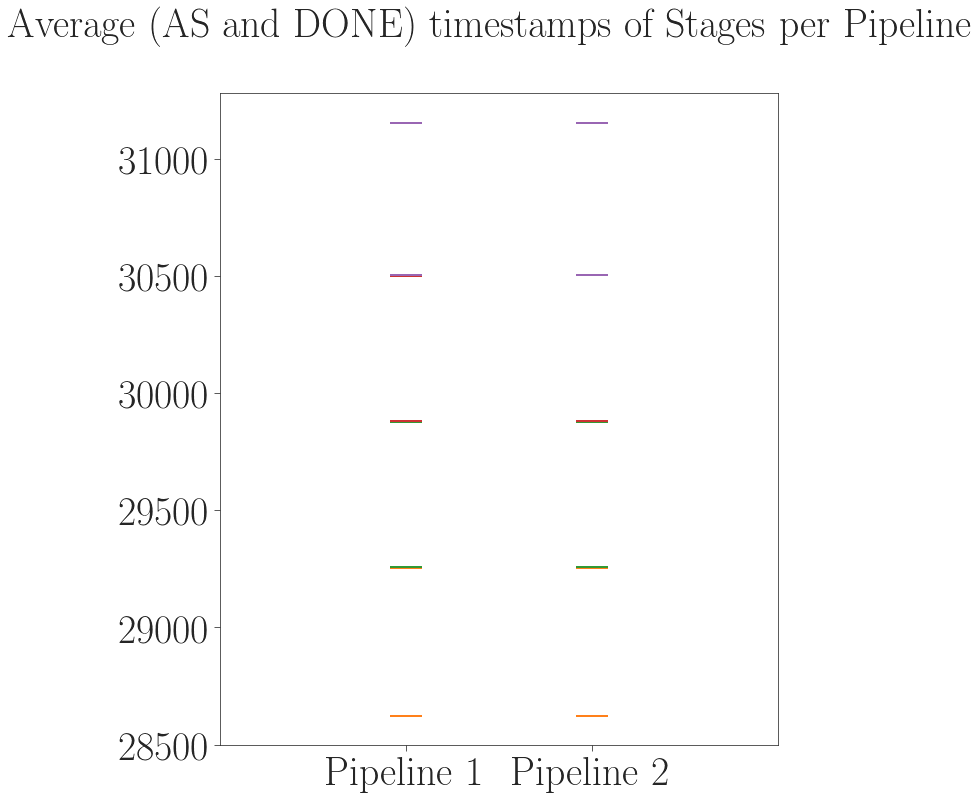

In [13]:
fig, axarr = plt.subplots(figsize=(10,12))
fig.suptitle('Average (AS and DONE) timestamps of Stages per Pipeline')
y_pos = [1,2]
bars = ['Pipeline 1', 'Pipeline 2']


marker_style = dict(marker='_', s=1000)

axarr.scatter(y_pos, pipelines['S1 (AS)'], color=tableau20[2], **marker_style)
axarr.scatter(y_pos, pipelines['S1 (DONE)'], color=tableau20[2], **marker_style)
axarr.scatter(y_pos, pipelines['S2 (AS)'], color=tableau20[4], **marker_style)
axarr.scatter(y_pos, pipelines['S2 (DONE)'], color=tableau20[4], **marker_style)
axarr.scatter(y_pos, pipelines['S3 (AS)'], color=tableau20[6], **marker_style)
axarr.scatter(y_pos, pipelines['S3 (DONE)'], color=tableau20[6], **marker_style)
axarr.scatter(y_pos, pipelines['S4 (AS)'], color=tableau20[8], **marker_style)
axarr.scatter(y_pos, pipelines['S4 (DONE)'], color=tableau20[8], **marker_style)


#axarr.set_yticklabels([29750,30000,30000,30500])
axarr.set_xticks([1,2])
axarr.set_xticklabels(["Pipeline 1","Pipeline 2"])
axarr.set_xlim([0,3])

# axarr.set_yticks()


# axarr[0].set_xlim(-1,20)
# axarr[0].xaxis.set_major_locator(MaxNLocator(integer=True))
# axarr[0].set_ylabel('Time (s)')
# axarr[0].set_title('Units of Stage 1')

### Durations/Stage (Seperate Pipelines)

In [51]:
# stage 1 
units_p1_s1 = session.filter(etype='unit', inplace=False, uid=sorted(session.list('uid'))[0:10])
p1_s1_duration = units_p1_s1.duration(state=['AGENT_SCHEDULING','DONE']) + pipelines.loc["Pipeline 1"]['S1 (AS)']


units_p2_s1 = session.filter(etype='unit', inplace=False, uid=sorted(session.list('uid'))[10:20])
p2_s1_duration = units_p2_s1.duration(state=['AGENT_SCHEDULING','DONE']) + pipelines.loc["Pipeline 2"]['S1 (AS)']

# stage 2
units_p1_s2 = session.filter(etype='unit', inplace=False, uid=sorted(session.list('uid'))[20:30])
p1_s2_duration = units_p1_s2.duration(state=['AGENT_SCHEDULING','DONE']) + pipelines.loc["Pipeline 1"]['S2 (AS)']

units_p2_s2 = session.filter(etype='unit', inplace=False, uid=sorted(session.list('uid'))[30:40])
p2_s2_duration = units_p2_s2.duration(state=['AGENT_SCHEDULING','DONE']) + pipelines.loc["Pipeline 2"]['S2 (AS)']

# stage 3
units_p1_s3 = session.filter(etype='unit', inplace=False, uid=sorted(session.list('uid'))[40:50])
p1_s3_duration = units_p1_s3.duration(state=['AGENT_SCHEDULING','DONE']) + pipelines.loc["Pipeline 1"]['S3 (AS)']

units_p2_s3 = session.filter(etype='unit', inplace=False, uid=sorted(session.list('uid'))[50:60])
p2_s3_duration = units_p2_s3.duration(state=['AGENT_SCHEDULING','DONE']) + pipelines.loc["Pipeline 2"]['S3 (AS)']

# stage 4

units_p1_s4 = session.filter(etype='unit', inplace=False, uid=sorted(session.list('uid'))[60:70])
p1_s4_duration = units_p1_s4.duration(state=['AGENT_SCHEDULING','DONE']) + pipelines.loc["Pipeline 1"]['S4 (AS)']

units_p2_s4 = session.filter(etype='unit', inplace=False, uid=sorted(session.list('uid'))[70:80])
p2_s4_duration = units_p2_s4.duration(state=['AGENT_SCHEDULING','DONE']) + pipelines.loc["Pipeline 2"]['S4 (AS)']

%store p1_s1_duration
%store p2_s1_duration

%store p1_s2_duration
%store p2_s2_duration

%store p1_s3_duration
%store p2_s3_duration

%store p1_s4_duration
%store p2_s4_duration


Stored 'p1_s1_duration' (float64)
Stored 'p2_s1_duration' (float64)
Stored 'p1_s2_duration' (float64)
Stored 'p2_s2_duration' (float64)
Stored 'p1_s3_duration' (float64)
Stored 'p2_s3_duration' (float64)
Stored 'p1_s4_duration' (float64)
Stored 'p2_s4_duration' (float64)


(0, 3)

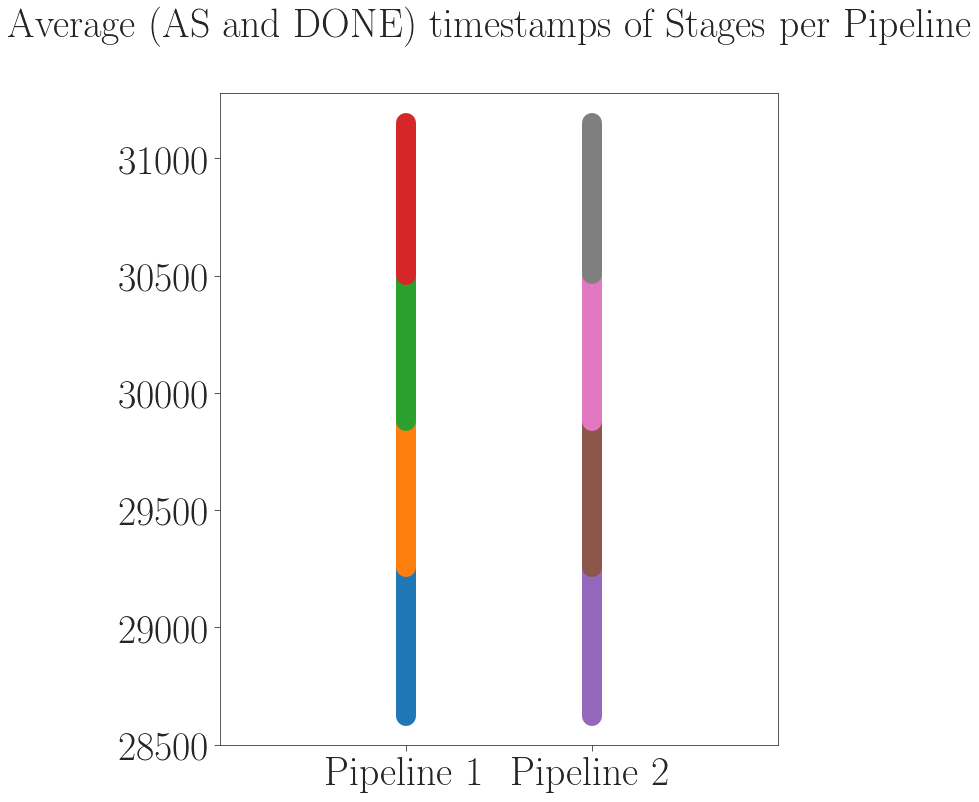

In [57]:
fig, axarr = plt.subplots(figsize=(10,12))
fig.suptitle('Average (AS and DONE) timestamps of Stages per Pipeline')
y_pos = [1,2]
bars = ['Pipeline 1', 'Pipeline 2']

marker_style = dict(linewidth=20)

# pipeline 1, all stages

axarr.plot([y_pos[0], y_pos[0]], [pipelines.loc["Pipeline 1"]['S1 (AS)'], p1_s1_duration], **marker_style)
axarr.plot([y_pos[0], y_pos[0]], [pipelines.loc["Pipeline 1"]['S2 (AS)'], p1_s2_duration], **marker_style)
axarr.plot([y_pos[0], y_pos[0]], [pipelines.loc["Pipeline 1"]['S3 (AS)'], p1_s3_duration], **marker_style)
axarr.plot([y_pos[0], y_pos[0]], [pipelines.loc["Pipeline 1"]['S4 (AS)'], p1_s4_duration], **marker_style)


# pipeline 2, all stages

axarr.plot([y_pos[1], y_pos[1]], [pipelines.loc["Pipeline 2"]['S1 (AS)'], p2_s1_duration], **marker_style)
axarr.plot([y_pos[1], y_pos[1]], [pipelines.loc["Pipeline 2"]['S2 (AS)'], p2_s2_duration], **marker_style)
axarr.plot([y_pos[1], y_pos[1]], [pipelines.loc["Pipeline 2"]['S3 (AS)'], p2_s3_duration], **marker_style)
axarr.plot([y_pos[1], y_pos[1]], [pipelines.loc["Pipeline 2"]['S4 (AS)'], p2_s4_duration], **marker_style)

# axarr.set_ylim(28620, 31260)
axarr.set_xticks([1,2])
axarr.set_xticklabels(["Pipeline 1","Pipeline 2"])
axarr.set_xlim([0,3])